## Part A: Loading/Preprocessing Rotten Tomatoes Data

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [3]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [4]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [5]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [6]:
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed


In [7]:
#Apply standardizing functions to synopsis and critic text
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   

                                              genres          directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...     Chris Columbus   
1                                             Comedy  Nicole Holofcener   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   
1                           Nicole Holofcener   

                                              actors original_release_date  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...            2010-02-12   
1  Catherine Keener, Amanda Peet, Oliver Platt, R...            2010-04-30   

  streaming_release_date  ...  num_actors num_actors_group  \
0             2015-11-25  ...        87.0           50-100   
1             2012-09-04  ...         8.0            10-25   

                                  cleaned_movie_info  \
0  always trouble prone life teenager percy jacks...   
1  kate catherine keener husband alex oliver plat...   

                           cleaned_critics_consensus  \
0  though may seem like another harry potter knoc...   
1  nicole holofcener newest might seem slight pla...   

                              synposis_scores_unpack  \
0  {'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...   
1  {'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...   

                                critic_scores_unpack  \
0  {'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...   
1  {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...   

   synopsis_sentiment_score  synopsis_sentiment_class  critic_sentiment_score  \
0                   -0.2023                         0                  0.9274   
1                    0.2023                         1                  0.3612   

   critic_sentiment_class  
0                       1  
1                       1  

[2 rows x 34 columns]

## Part B: Referencing Kaggle
https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide

In [10]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['original_release_date'], format = '%Y/%m/%d')

## Part B1: Data Viz

In [11]:
#Filter data down a bit
filter_df = df[df['original_release_date']>='2000-01-01']
filter_df = filter_df[['date','critic_sentiment_score','synopsis_sentiment_score','tomatometer_rating','audience_rating']]
filter_df.head()

date  critic_sentiment_score  synopsis_sentiment_score  \
0  2010-02-12                  0.9274                   -0.2023   
1  2010-04-30                  0.3612                    0.2023   
5  2008-03-07                  0.5106                    0.8860   
8  2002-09-27                  0.0000                    0.8658   
10 2002-01-19                  0.0000                   -0.8617   

    tomatometer_rating  audience_rating  
0                 49.0             53.0  
1                 87.0             64.0  
5                  8.0             37.0  
8                 20.0             87.0  
10                80.0             66.0

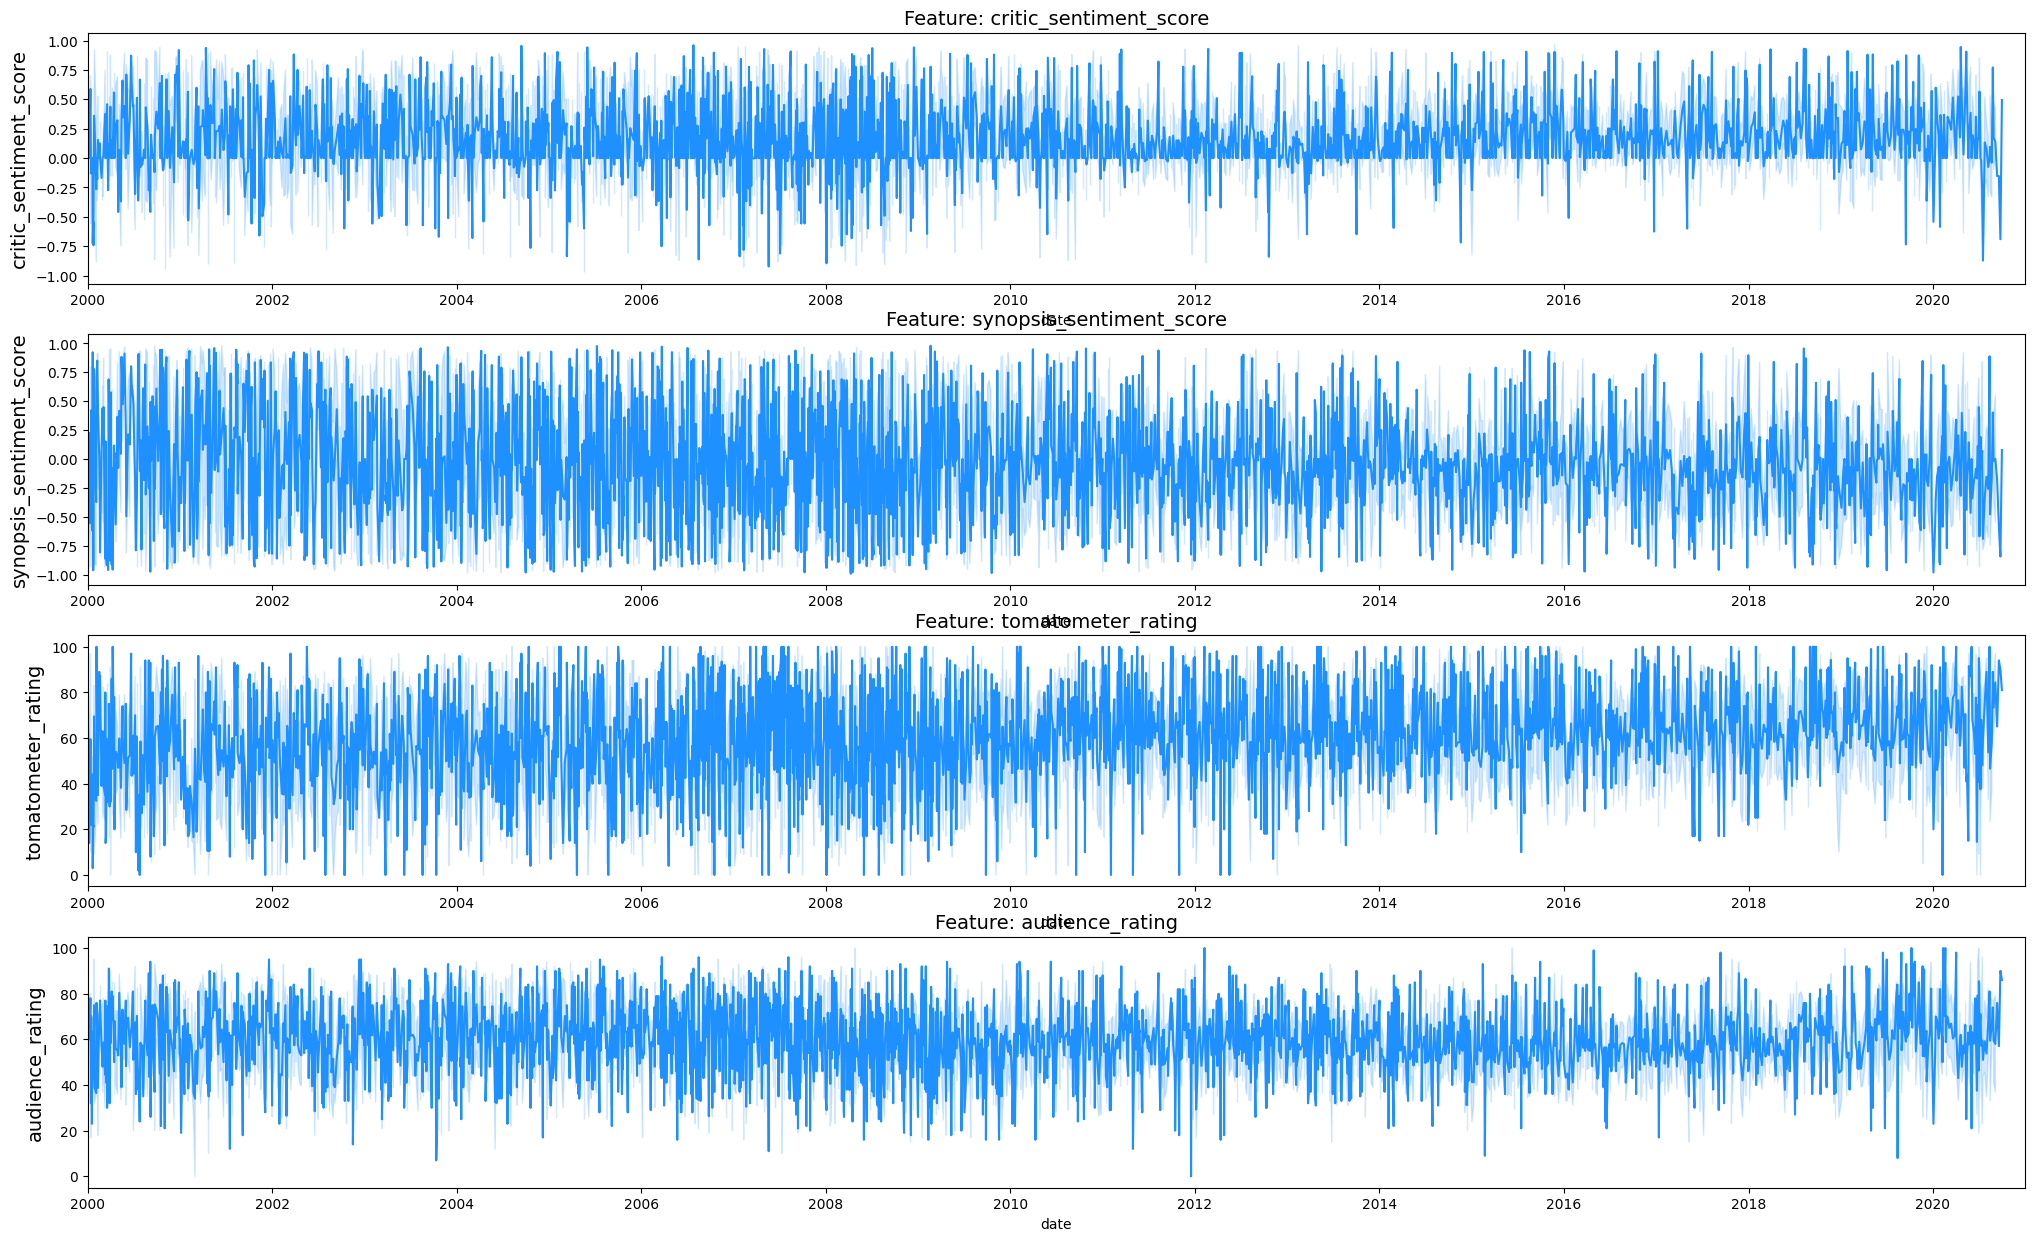

In [12]:
# To compelte the data, as naive method, we will use ffill
import seaborn as sns
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 15))

for i, column in enumerate(filter_df.drop('date', axis=1).columns):
    sns.lineplot(x=filter_df['date'], y=filter_df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2000, 1, 1), date(2020, 12, 31)])

## Part B2: Data Preprocessing

Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [13]:
#Create new dataframe with one row per day
df = df.groupby('date').agg({
    'critic_sentiment_score': 'mean',
    'synopsis_sentiment_score':'mean',
    'tomatometer_rating':'mean',
    'audience_rating':'mean'
}).reset_index()
df.head()

date  critic_sentiment_score  synopsis_sentiment_score  \
0 1914-06-01                  0.0000                   -0.9477   
1 1915-01-01                  0.0000                    0.7003   
2 1915-03-03                 -0.7037                   -0.7964   
3 1916-09-05                  0.6597                   -0.2732   
4 1919-05-13                  0.1531                   -0.7096   

   tomatometer_rating  audience_rating  
0                96.0             69.0  
1                83.0             53.0  
2                93.0             56.0  
3                97.0             77.0  
4                95.0             71.0

In [14]:
df = df[df['date']>='2000-01-01']
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

date  delta
3231 2000-01-01    NaT
3232 2000-01-02 1 days
3233 2000-01-07 5 days
3234 2000-01-12 5 days
3235 2000-01-14 2 days

In [15]:
df['delta'].sum(), df['delta'].count()

(Timedelta('7578 days 00:00:00'), 2506)

In [16]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                         0
critic_sentiment_score       0
synopsis_sentiment_score     0
tomatometer_rating           1
audience_rating             21
dtype: int64

(14610.0, 18262.0)

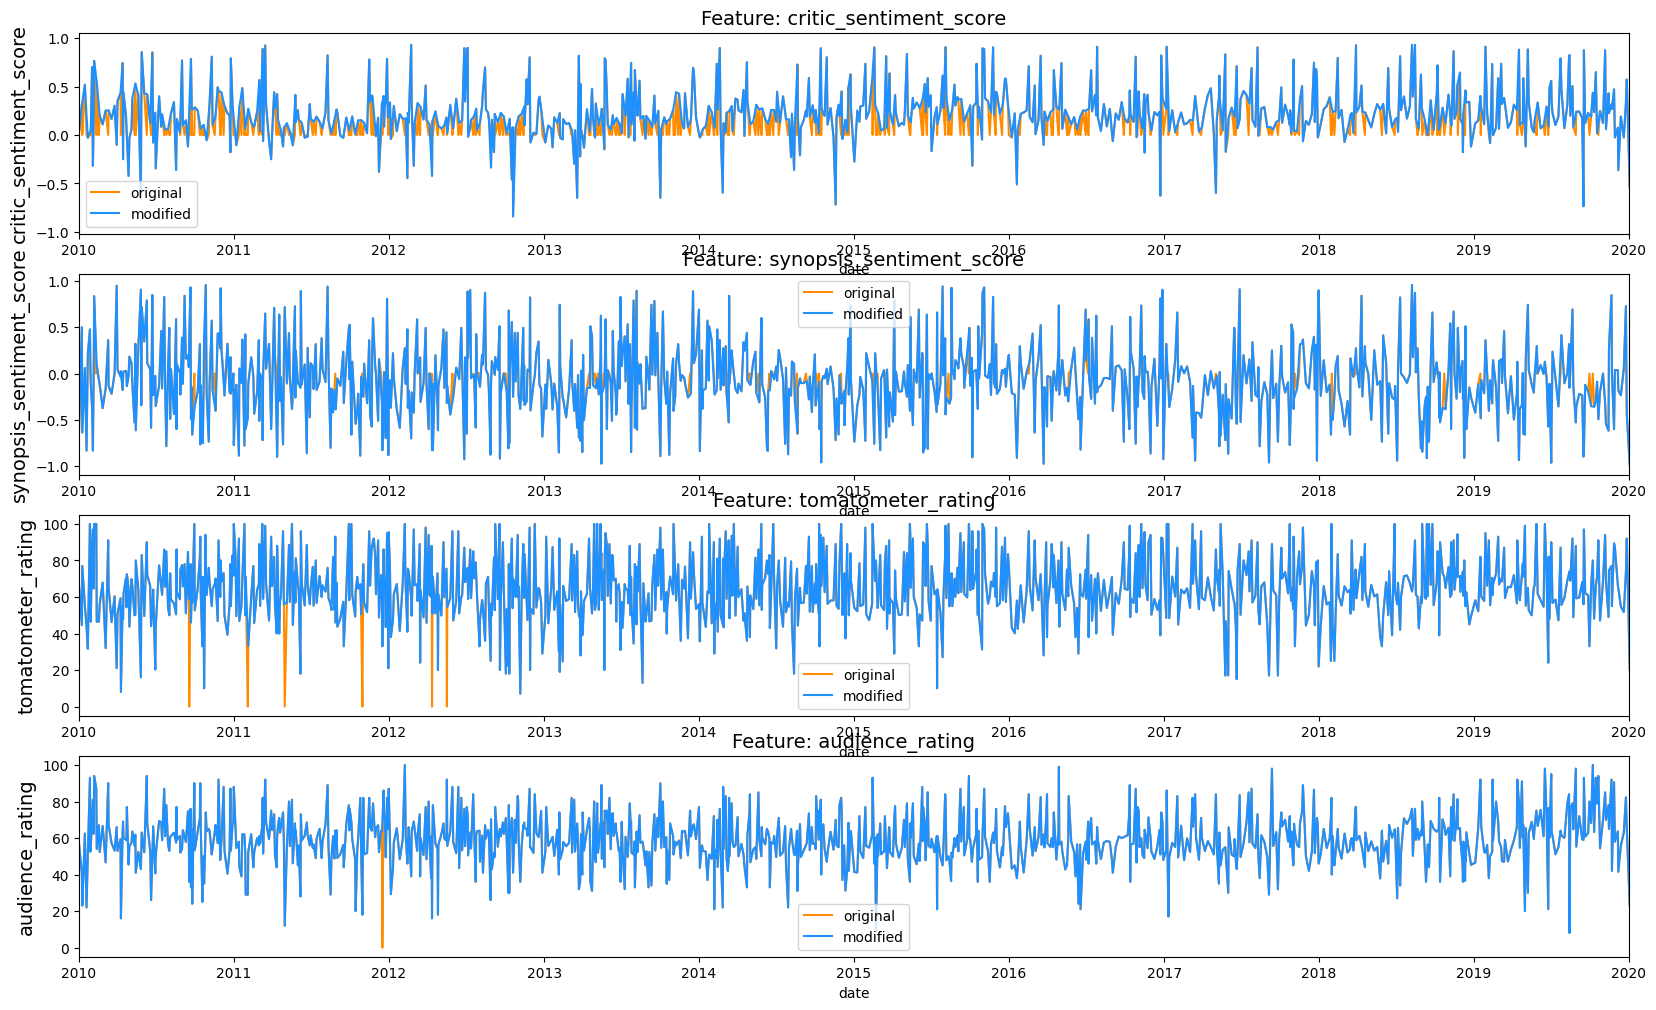

In [17]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))

old_critic = df['critic_sentiment_score'].copy()
df['critic_sentiment_score'] = df['critic_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_critic, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: critic_sentiment_score', fontsize=14)
ax[0].set_ylabel(ylabel='critic_sentiment_score', fontsize=14)
ax[0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_synop = df['synopsis_sentiment_score'].copy()
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_synop, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: synopsis_sentiment_score', fontsize=14)
ax[1].set_ylabel(ylabel='synopsis_sentiment_score', fontsize=14)
ax[1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])


old_tomato = df['tomatometer_rating'].copy()
df['tomatometer_rating'] = df['tomatometer_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_tomato, ax=ax[2], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['tomatometer_rating'].fillna(np.inf), ax=ax[2], color='dodgerblue', label='modified')
ax[2].set_title('Feature: tomatometer_rating', fontsize=14)
ax[2].set_ylabel(ylabel='tomatometer_rating', fontsize=14)
ax[2].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_audience = df['audience_rating'].copy()
df['audience_rating'] = df['audience_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_audience, ax=ax[3], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['audience_rating'].fillna(np.inf), ax=ax[3], color='dodgerblue', label='modified')
ax[3].set_title('Feature: audience_rating', fontsize=14)
ax[3].set_ylabel(ylabel='audience_rating', fontsize=14)
ax[3].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

So now we have to fix missing values. Lets take a look of these cases and explore what can we do with them.

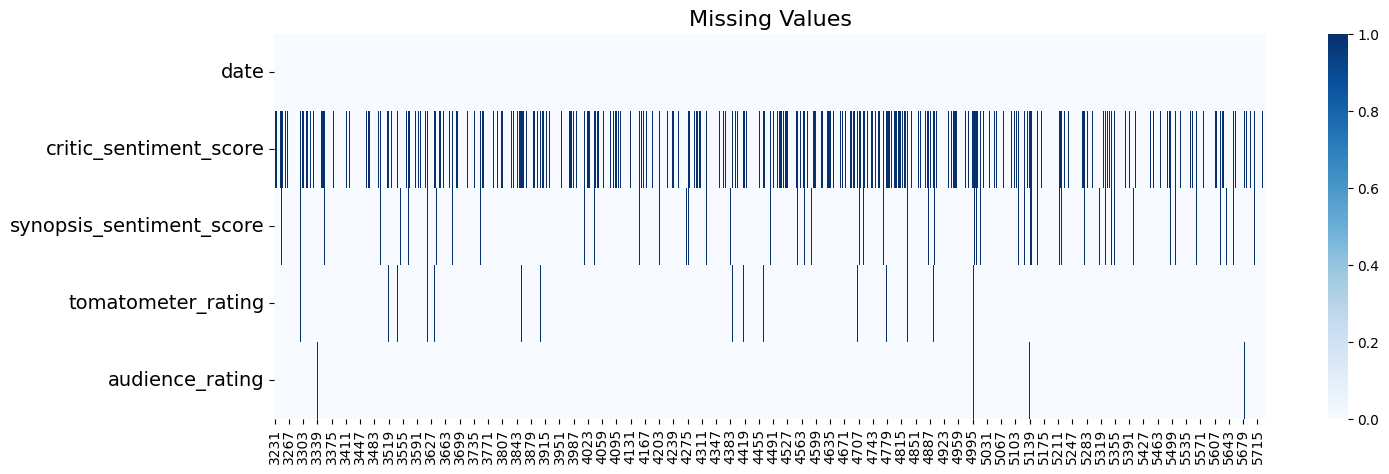

In [18]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

## Missing Values, how to handle
Option 1: Fill NaN with Outlier or Zero
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

Option 2: Fill NaN with Mean Value
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

Option 3: Fill NaN with Last Value with .ffill()
Filling NaNs with the last value could be bit better.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value



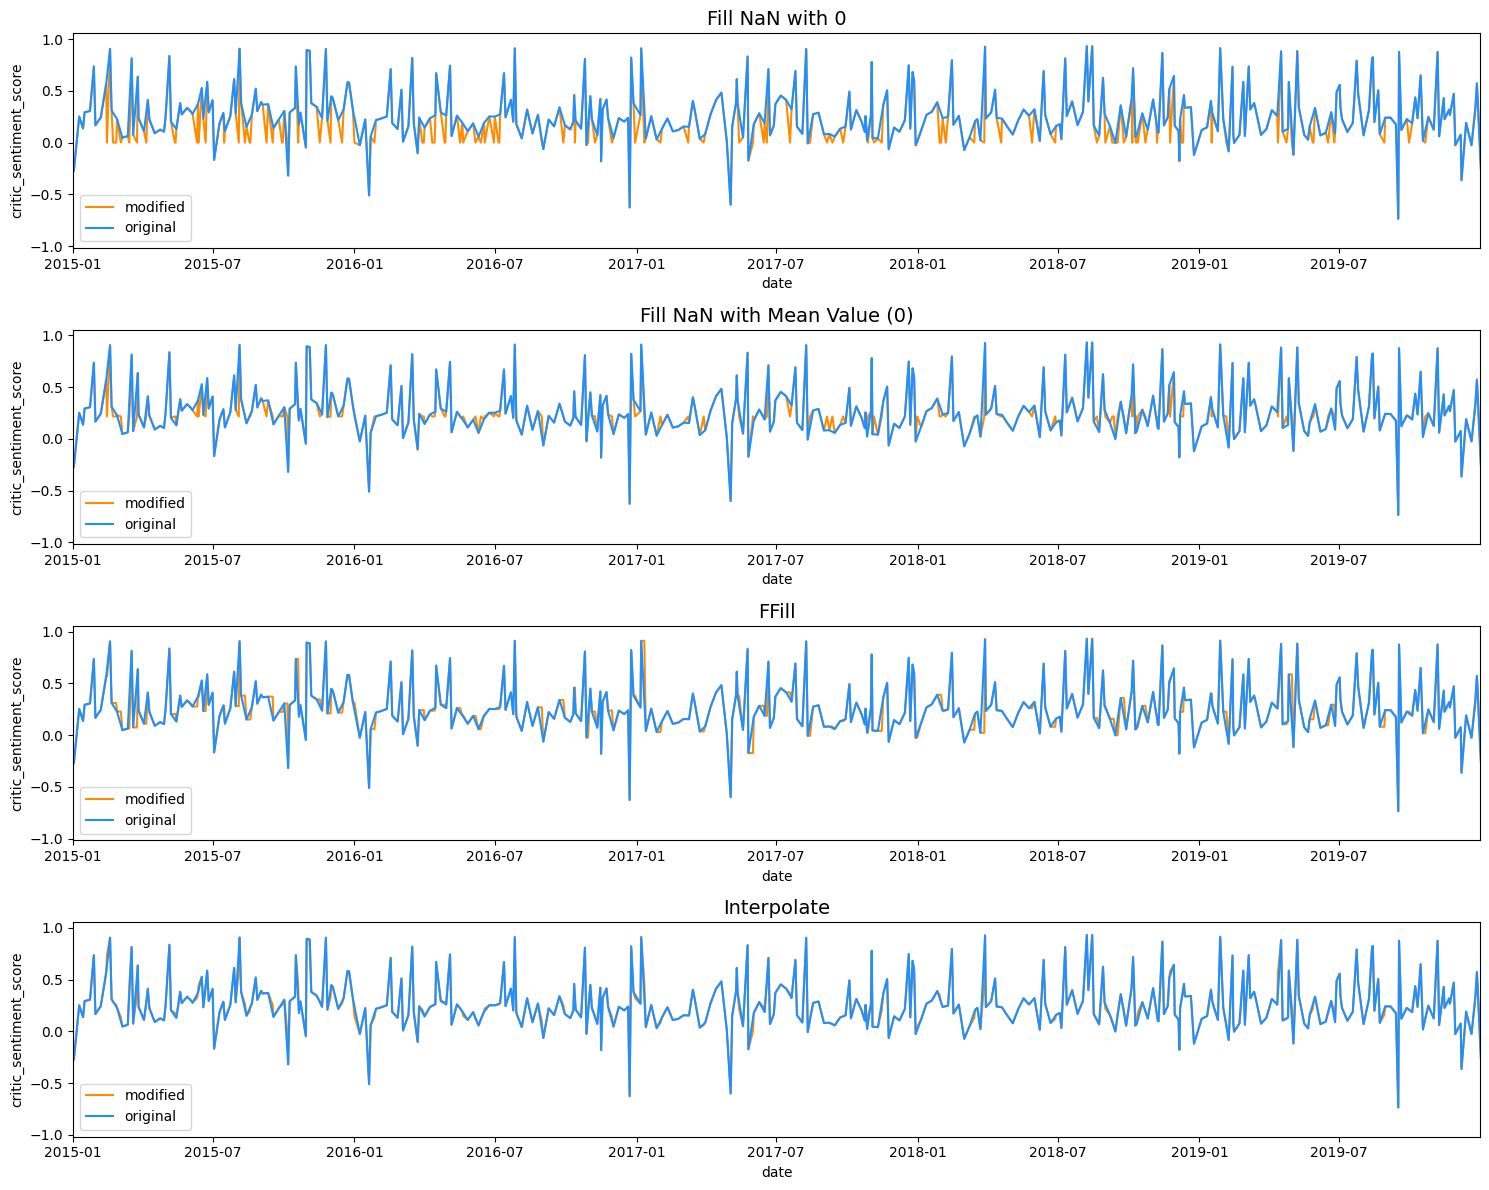

In [22]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)

mean_critc_sentiment = df['critic_sentiment_score'].mean()
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(mean_critc_sentiment), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_critc_sentiment:.0f})', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2015, 1, 1), date(2019, 12, 31)])
    
plt.tight_layout()
plt.show()


#### Fill NAs with 0 --> not best solution, but makes sense within context of our data, no movies released, so no critic scores, thus 0

In [24]:
df['critic_sentiment_score'] = df['critic_sentiment_score'].fillna(0)
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].fillna(0)
df['tomatometer_rating'] = df['tomatometer_rating'].fillna(0)
df['audience_rating'] = df['audience_rating'].fillna(0)

df.isnull().sum()

date                        0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             0
dtype: int64

## Smoothing / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

Upsampling is when the frequency of samples is increased (e.g. days to hours)

Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

In [26]:
df.columns

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating'],
      dtype='object')

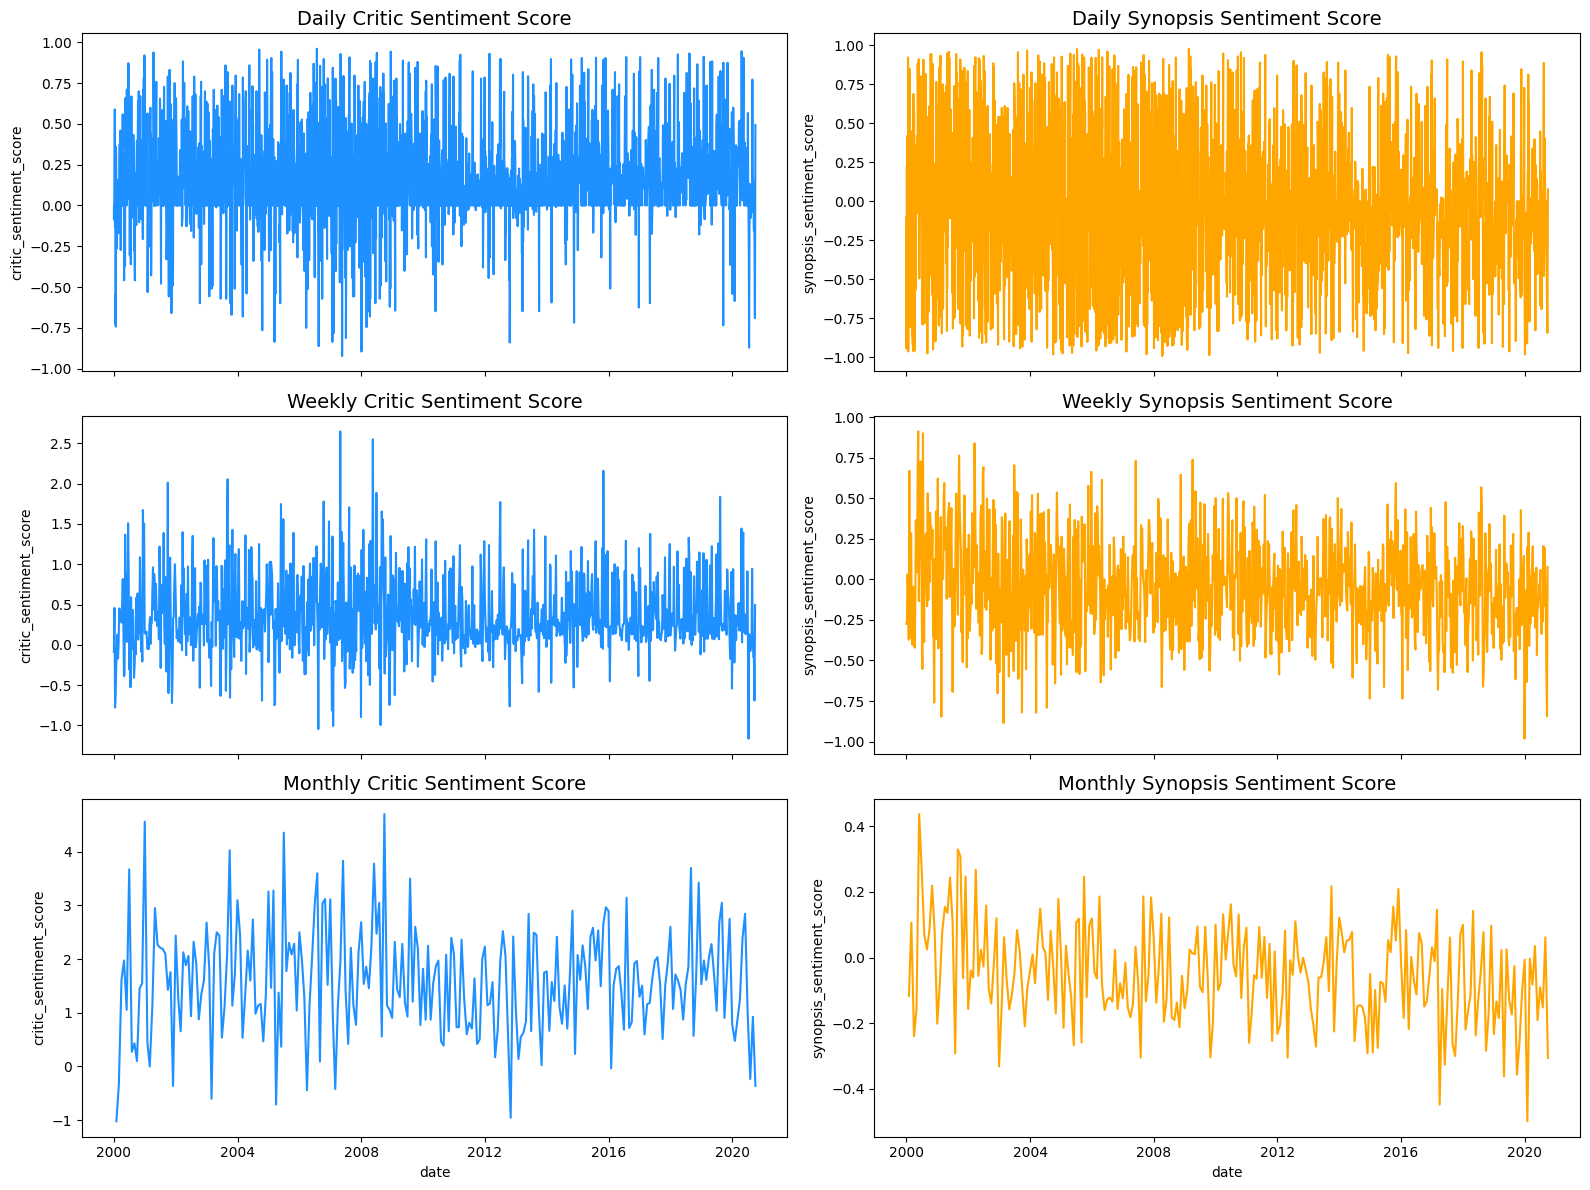

In [51]:
f, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily Critic Sentiment Score', fontsize=14)

resampled_df = df[['date','critic_sentiment_score']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Critic Sentiment Score', fontsize=14)

resampled_df = df[['date','critic_sentiment_score']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Critic Sentiment Score', fontsize=14)


sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'], color='orange', ax=ax[0, 1])
ax[0, 1].set_title('Daily Synopsis Sentiment Score', fontsize=14)

resampled_df = df[['date','synopsis_sentiment_score']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['synopsis_sentiment_score'], color='orange', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Synopsis Sentiment Score', fontsize=14)

resampled_df = df[['date','synopsis_sentiment_score']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['synopsis_sentiment_score'], color='orange', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Synopsis Sentiment Score', fontsize=14)

plt.tight_layout()
plt.show()

In [53]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date', 'critic_sentiment_score', 'synopsis_sentiment_score','tomatometer_rating', 'audience_rating'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity

#### Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

1.) constant mean and mean is not time-dependent

2.) constant variance and variance is not time-dependent

3.) constant covariance and covariance is not time-dependent


#### The check for stationarity can be done via three different approaches:

1.) visually: plot time series and check for trends or seasonality

2.) basic statistics: split time series and compare the mean and variance of each partition

3.) statistical test: Augmented Dickey Fuller test

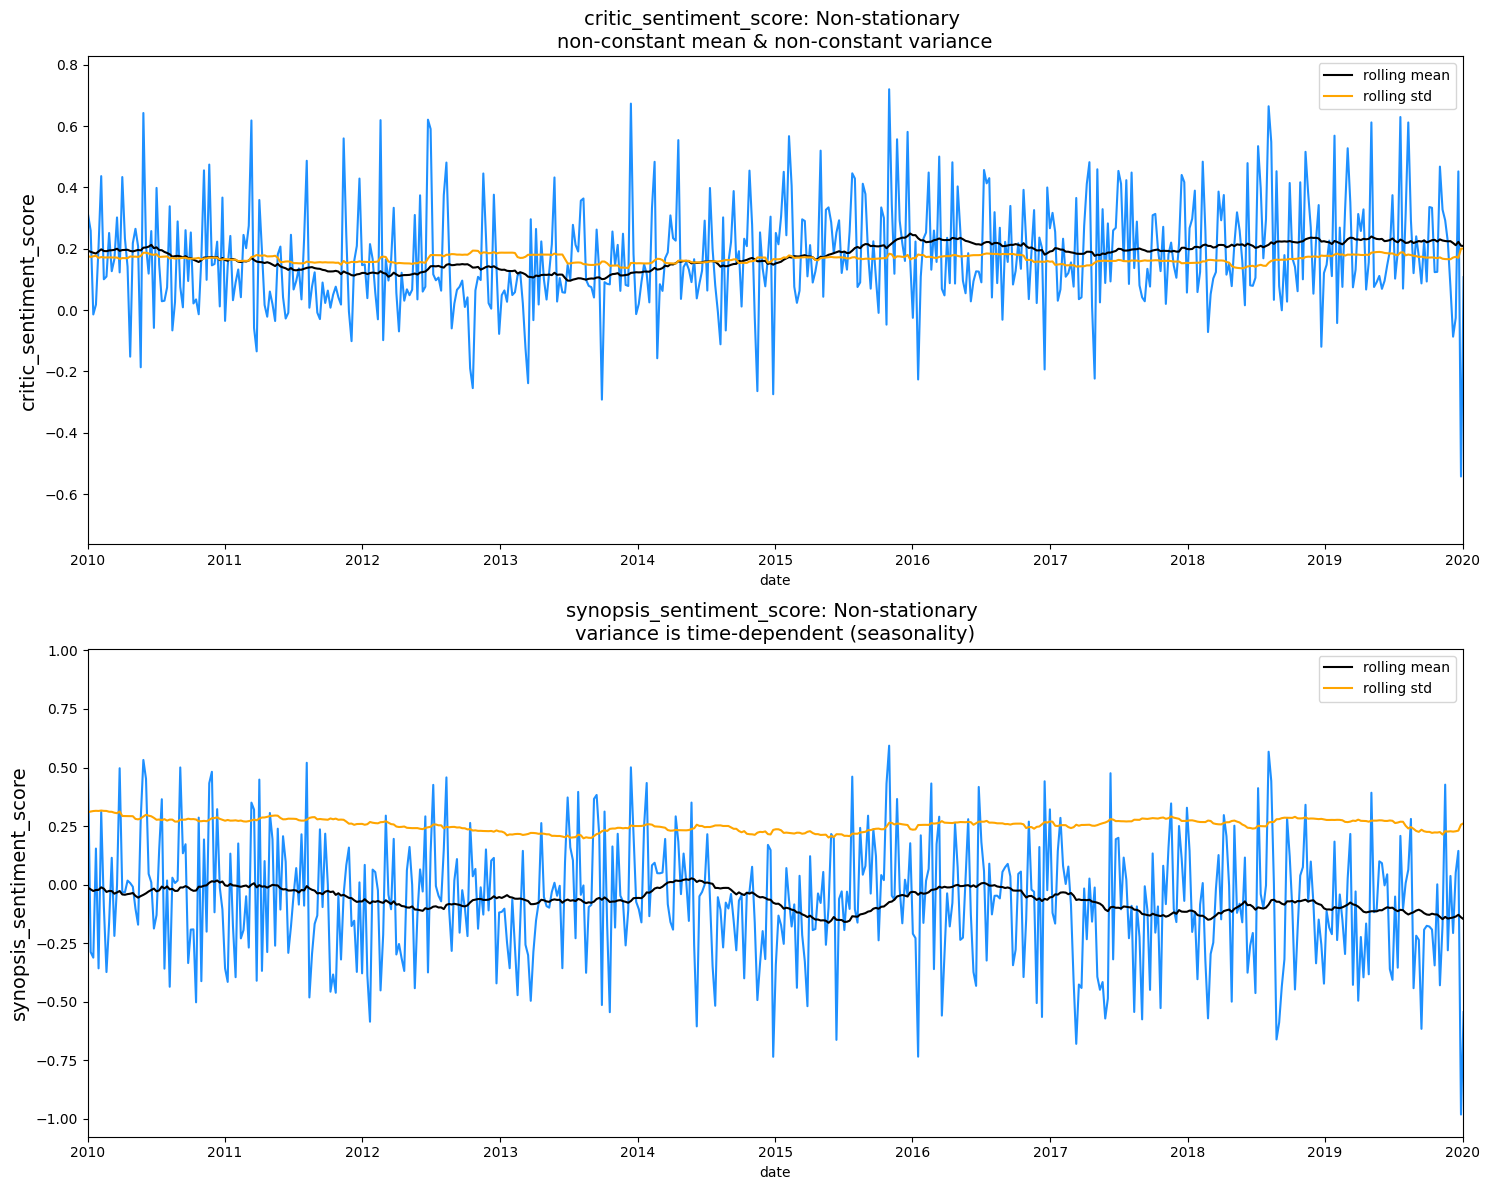

In [57]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('critic_sentiment_score: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='critic_sentiment_score', fontsize=14)
ax[0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('synopsis_sentiment_score: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='synopsis_sentiment_score', fontsize=14)
ax[1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

plt.tight_layout()
plt.show()

## Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. The ADF test belongs to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in the below equation:

Y
t
=
α
Y
t
−
1
+
β
X
e
+
ϵ
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

## Augmented Dickey-Fuller (ADF)

The Augmented Dickey-Fuller (ADF) test is a type of statistical test, which is also referred to as a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [58]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['critic_sentiment_score'].values)
result

(-31.35037303292738,
 0.0,
 0,
 1082,
 {'1%': -3.4364081161854747,
  '5%': -2.8642149051061954,
  '10%': -2.5681942108302214},
 -493.83071898456774)

Now, we are going to check for each variable:

(1) Check if the p-value is less than 0.05 or (2) check the range of the ADF statistic compared with the critical value.

In [59]:
df.columns

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating'],
      dtype='object')

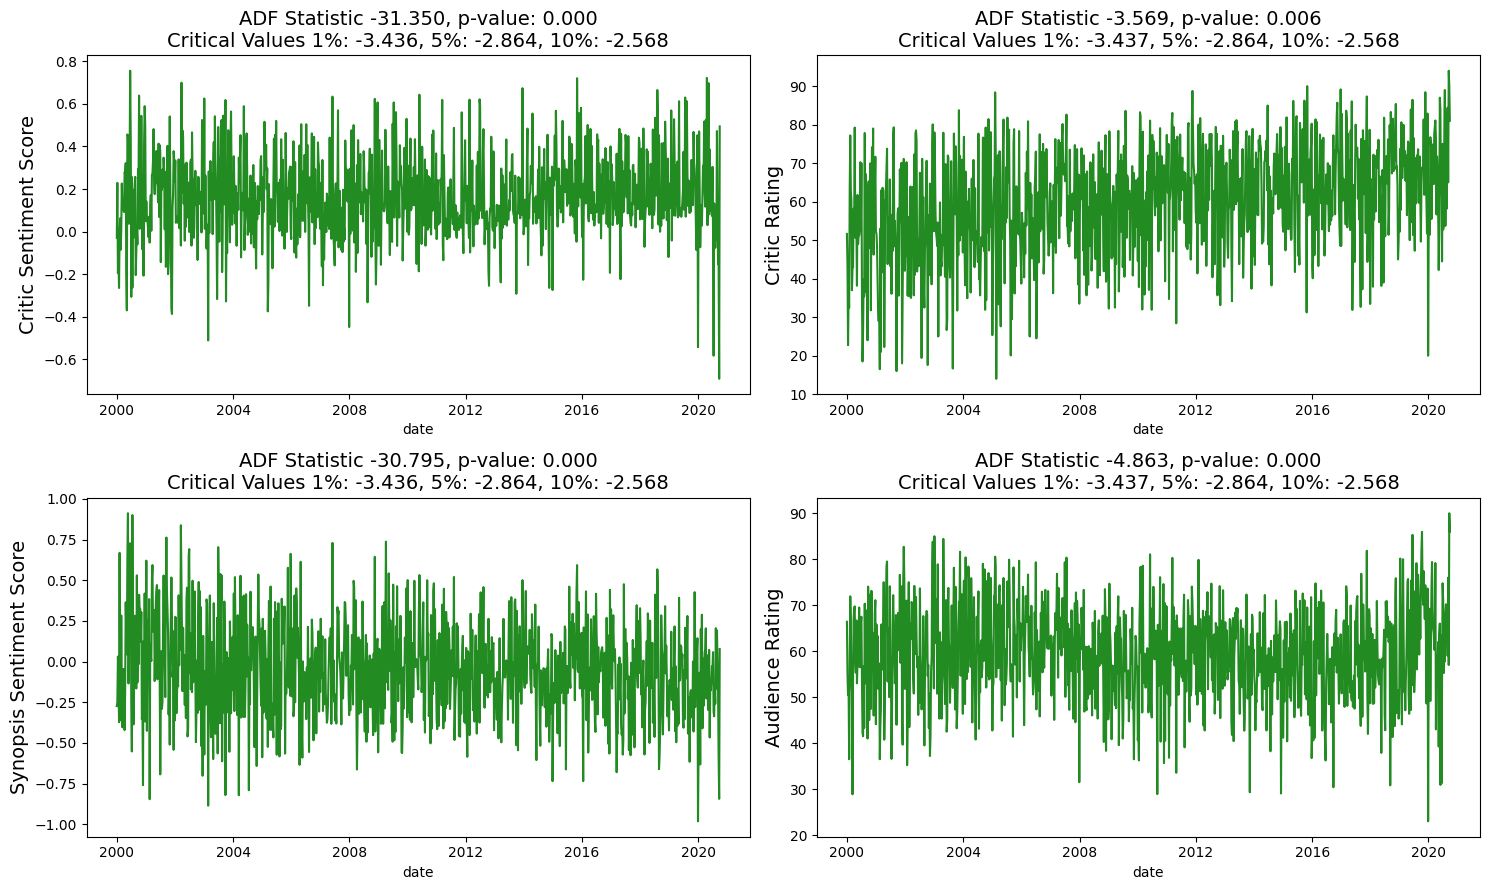

In [60]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['critic_sentiment_score'].values, 'Critic Sentiment Score', ax[0, 0])
visualize_adfuller_results(df['synopsis_sentiment_score'].values, 'Synopsis Sentiment Score', ax[1, 0])
visualize_adfuller_results(df['tomatometer_rating'].values, 'Critic Rating', ax[0, 1])
visualize_adfuller_results(df['audience_rating'].values, 'Audience Rating', ax[1, 1])

plt.tight_layout()
plt.show()

If the data is not stationary, but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

1.) Transformation: e.g. log or square root to stabilize non-constant variance

2.) Differencing: subtracts the current value from the previous

## Part C: Feature Engineering

In [61]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

date  year  month  day  day_of_year  week_of_year  quarter  season
0 2000-01-01  2000      1    1            1            52        1       1
1 2000-01-08  2000      1    8            8             1        1       1
2 2000-01-15  2000      1   15           15             2        1       1
3 2000-01-22  2000      1   22           22             3        1       1
4 2000-01-29  2000      1   29           29             4        1       1

### Part C2: Encode Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

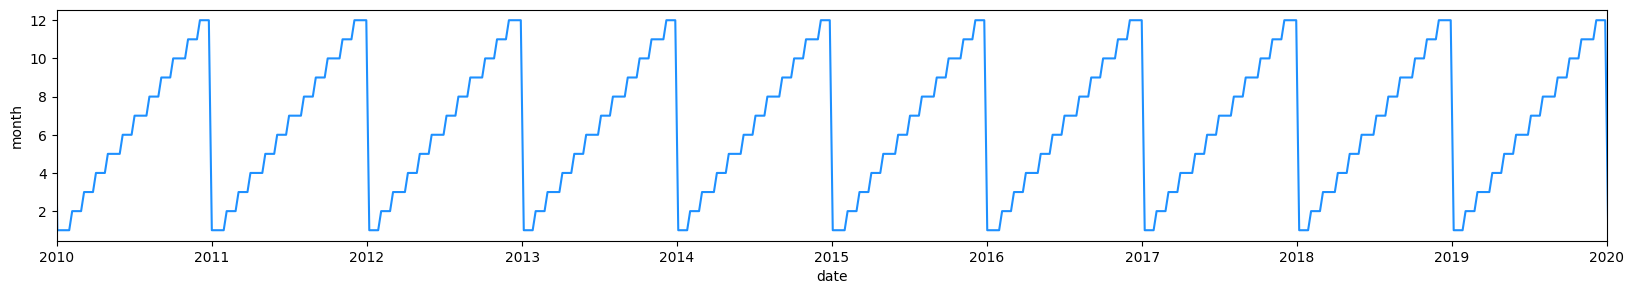

In [63]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
plt.show()

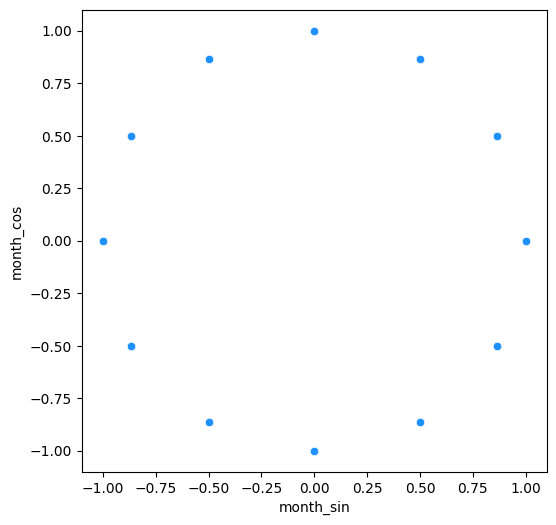

In [64]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

### Part 3C: Time Series Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

(1) Level: The average value in the series. (2) Trend: The increasing or decreasing value in the series. (3) Seasonality: The repeating short-term cycle in the series. (4)Noise: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

Additive:  
y
(
t
)
=
L
e
v
e
l
+
T
r
e
n
d
+
S
e
a
s
o
n
a
l
i
t
y
+
N
o
i
s
e
 
Multiplicative:  
y
(
t
)
=
L
e
v
e
l
∗
T
r
e
n
d
∗
S
e
a
s
o
n
a
l
i
t
y
∗
N
o
i
s
e
 
In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [66]:
df.columns

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating', 'year', 'month', 'day',
       'day_of_year', 'week_of_year', 'quarter', 'season', 'month_sin',
       'month_cos'],
      dtype='object')

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'critic_sentiment_score', 'synopsis_sentiment_score', 'tomatometer_rating', 'audience_rating'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

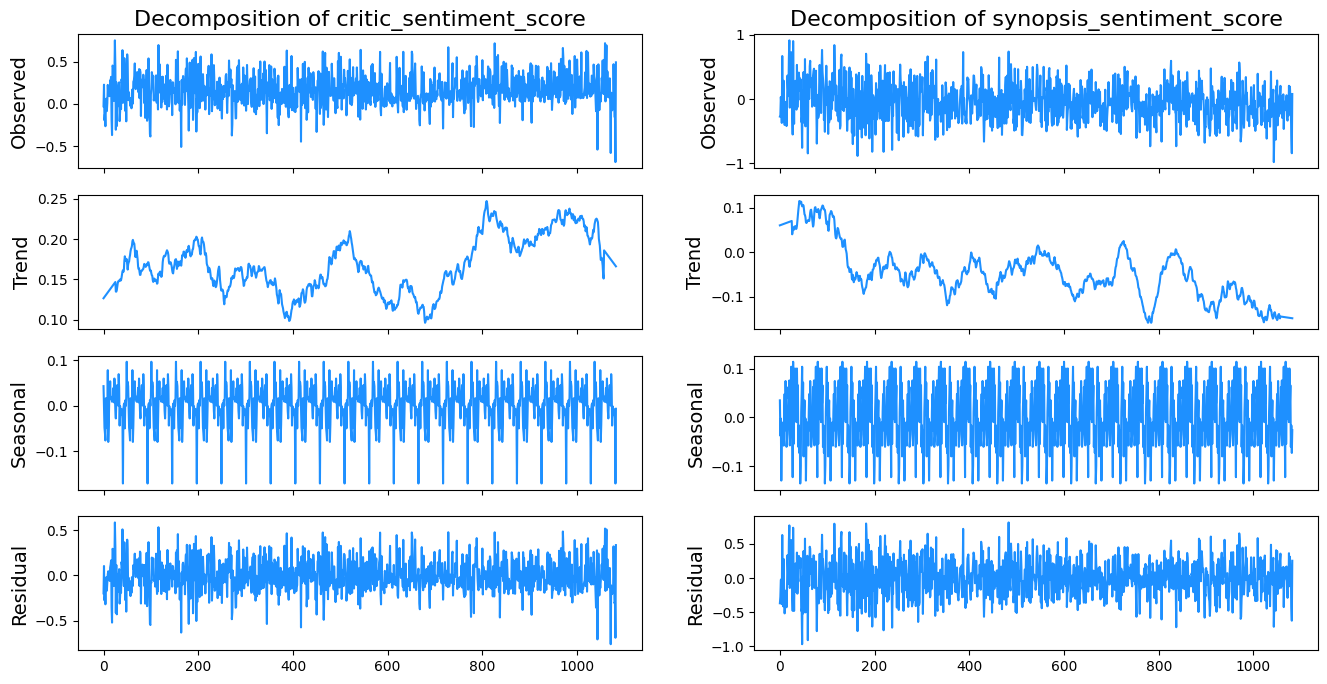

In [72]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['critic_sentiment_score', 'synopsis_sentiment_score']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Part 3D: Lag

We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

In [73]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## Part 4: Exploratory Data Analysis

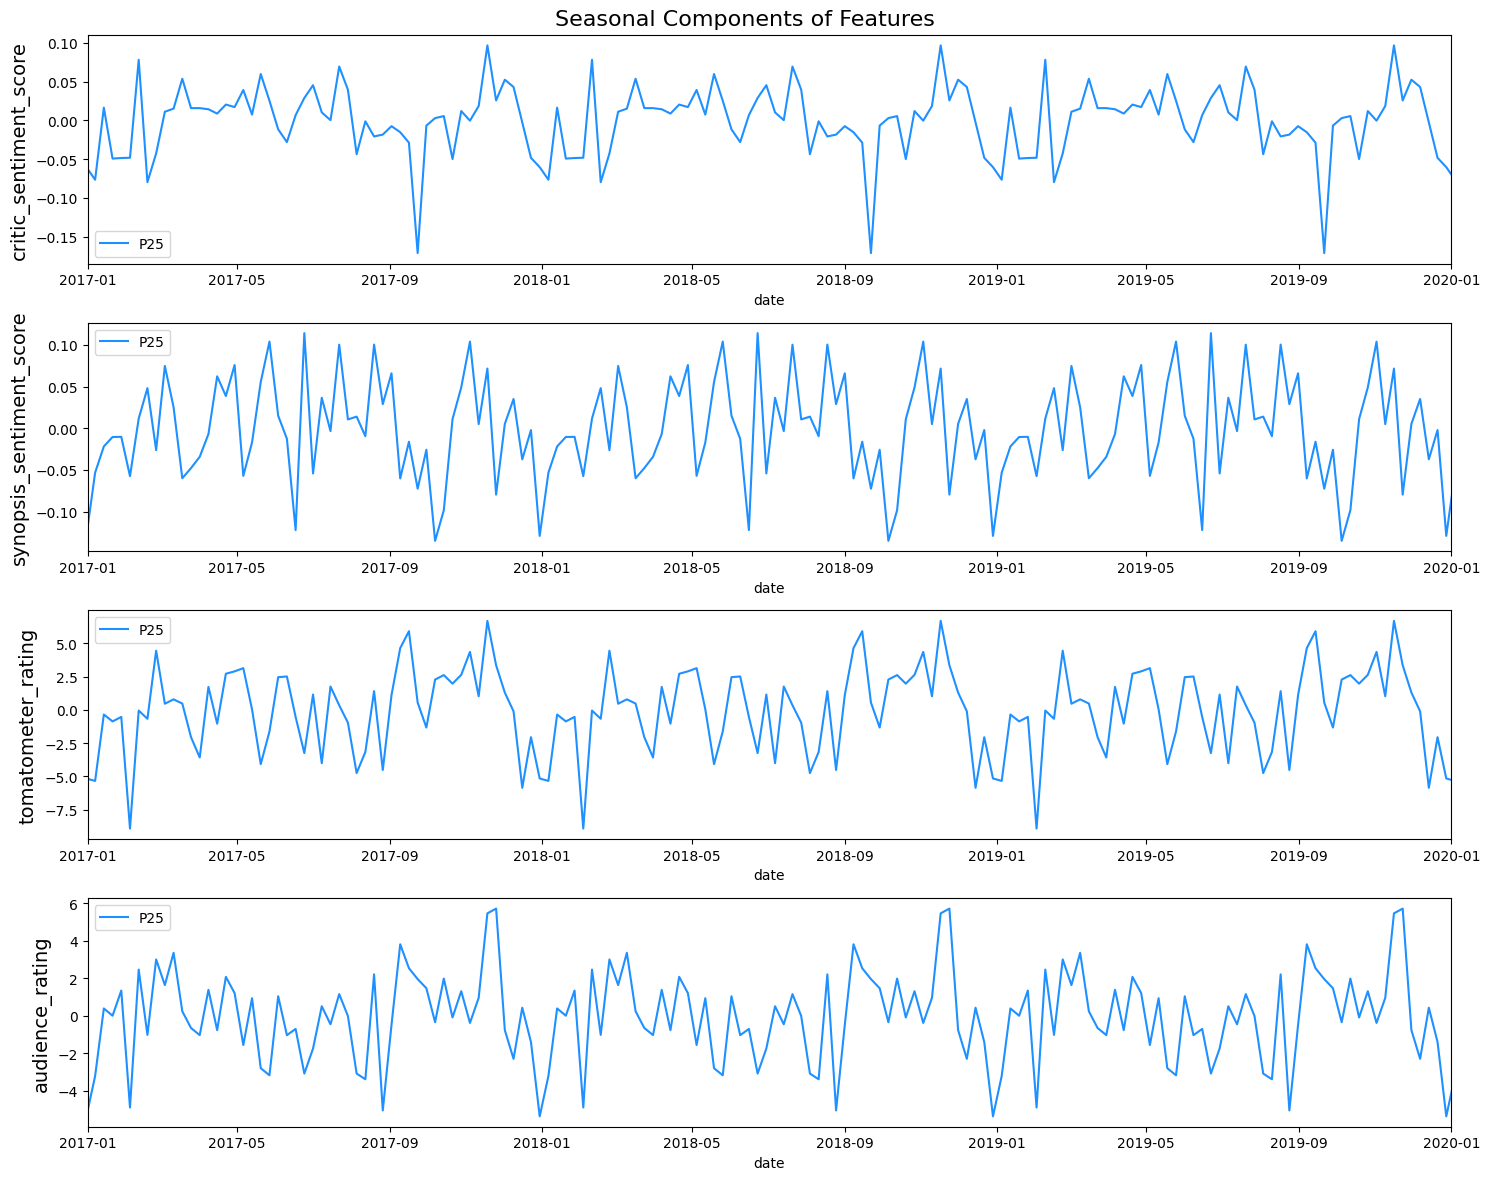

In [77]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 1, 1), date(2020, 1, 1)])
    
plt.tight_layout()
plt.show()

As we can see:

(1) critic_sentiment_score: reaches its minimum around October/November and its maximum around May/June

(2) synopsis_sentiment_socre: reaches its minimum around December and February

(3) critic rating: reaches its max around September and December and minimum around May.

(4) audience_rating: reaches its maximum around July/August and its minimum around January

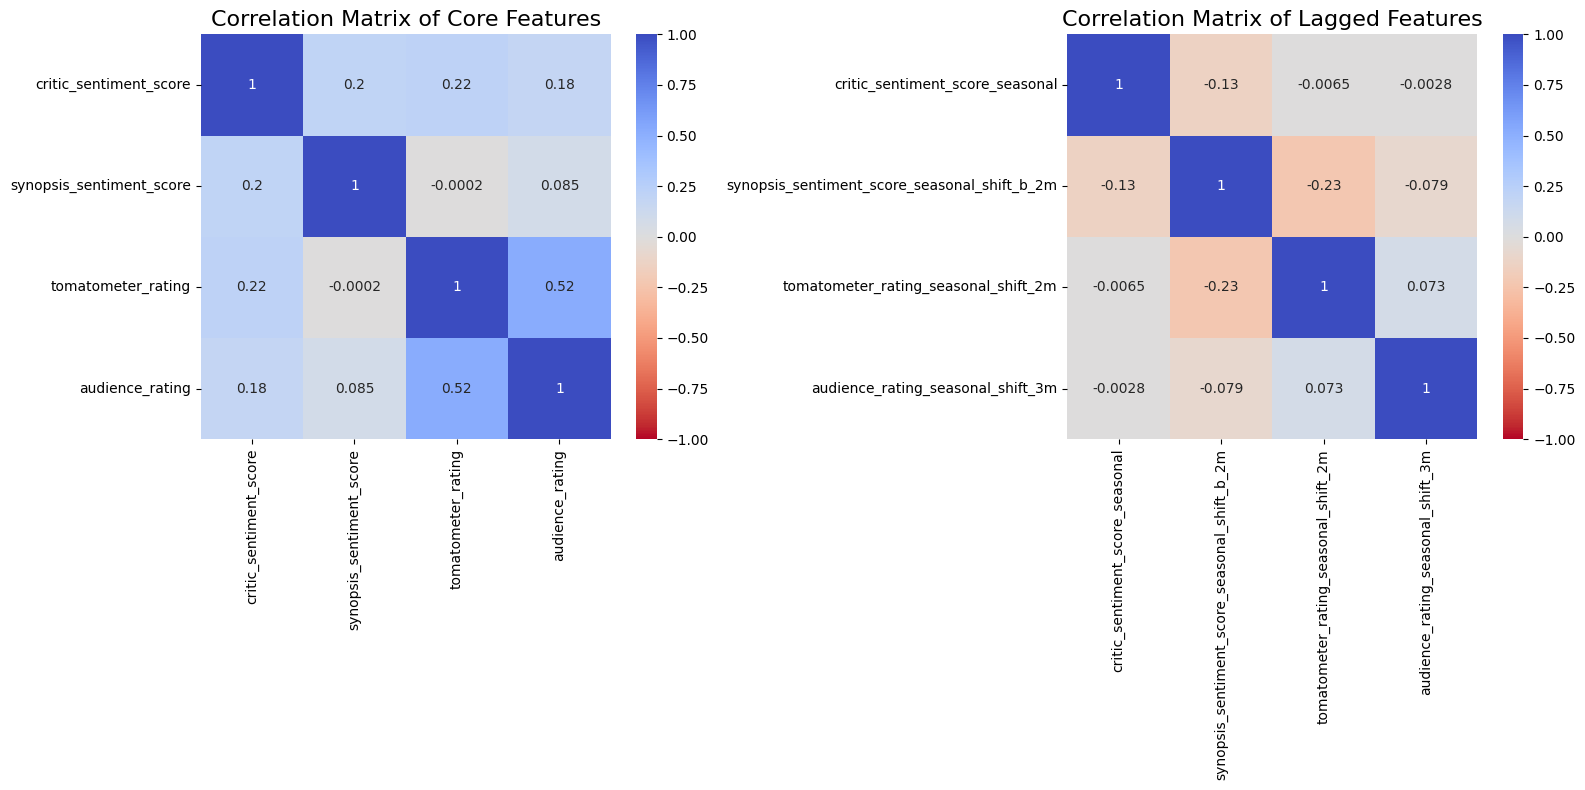

In [78]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'critic_sentiment_score_seasonal',         
    'synopsis_sentiment_score_seasonal_shift_b_2m',
    'tomatometer_rating_seasonal_shift_2m', 
    'audience_rating_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

As we can see, the features are more highly correlated with the original features rather than the shifted (lagged) ones. Still, not great numbers though.

## Part 4B: Autocorrelation Analysis

ACF and PACF plots: 

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

(1) Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter

(2) Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

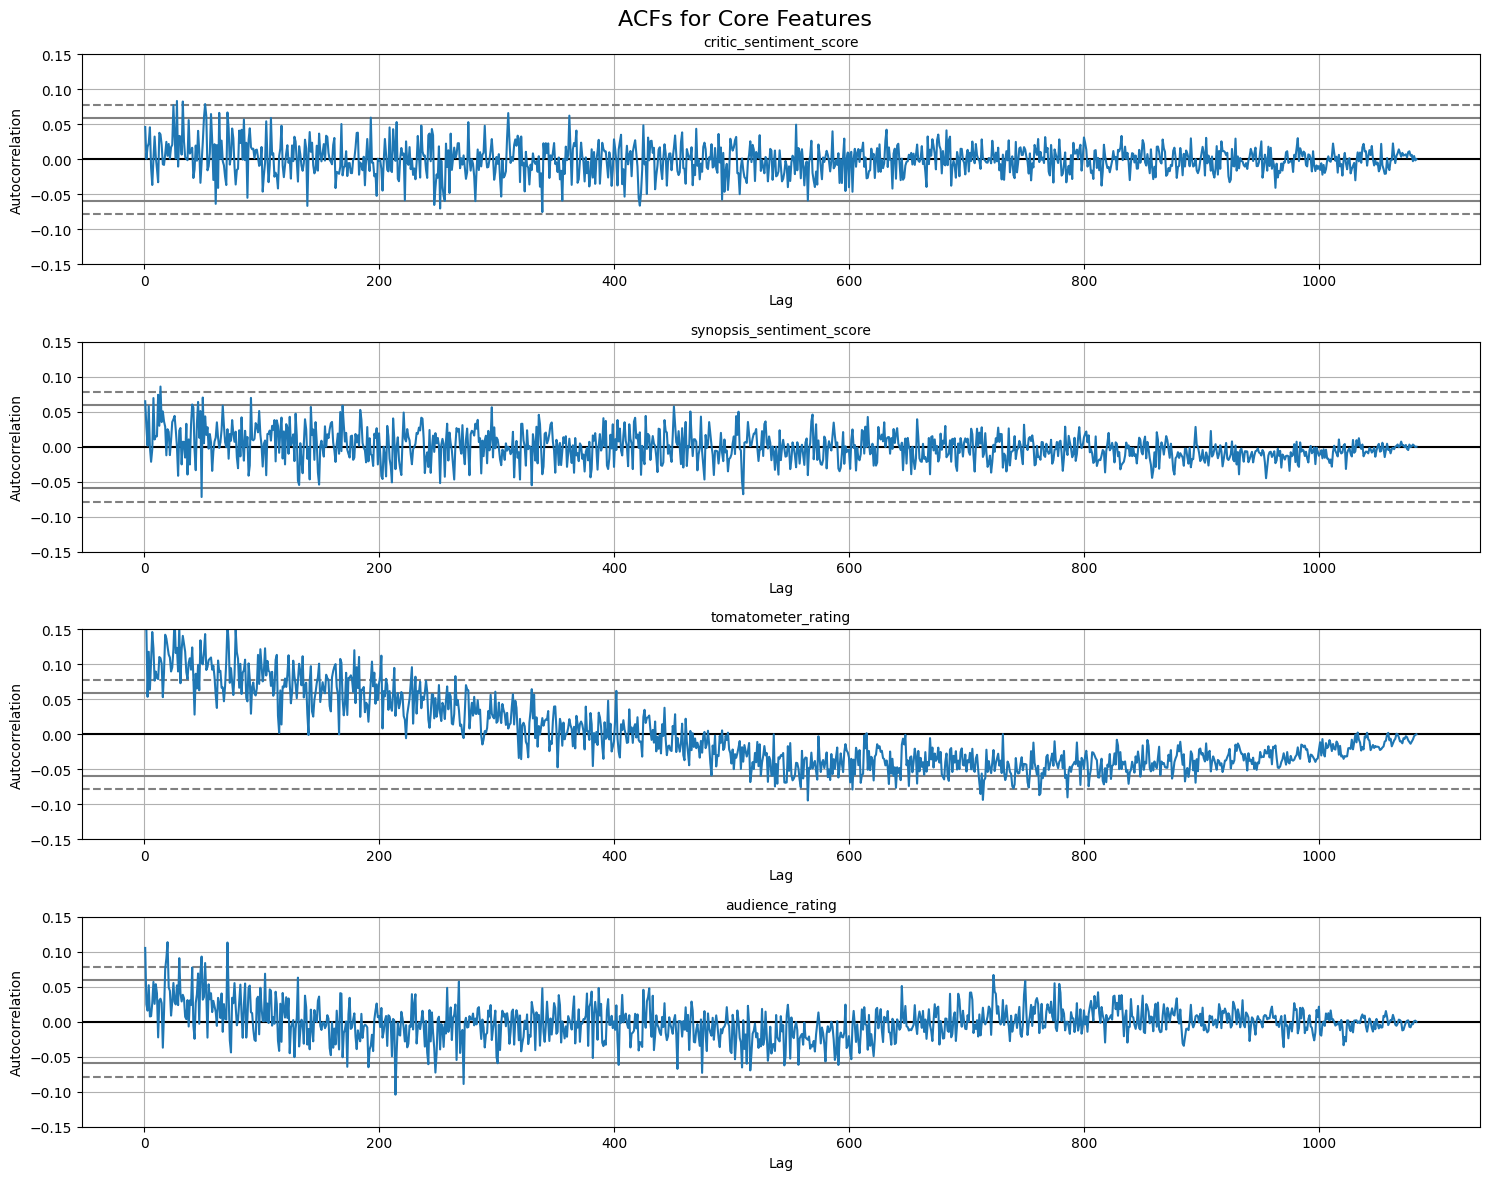

In [90]:
from pandas.plotting import autocorrelation_plot

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
f.suptitle('ACFs for Core Features', fontsize=16)

for i, column in enumerate(core_columns):
    autocorrelation_plot(df[column],ax=ax[i])
    ax[i].set_ylim([-0.15,0.15])
    ax[i].set_title(column, fontsize=10)


plt.tight_layout()
plt.show()

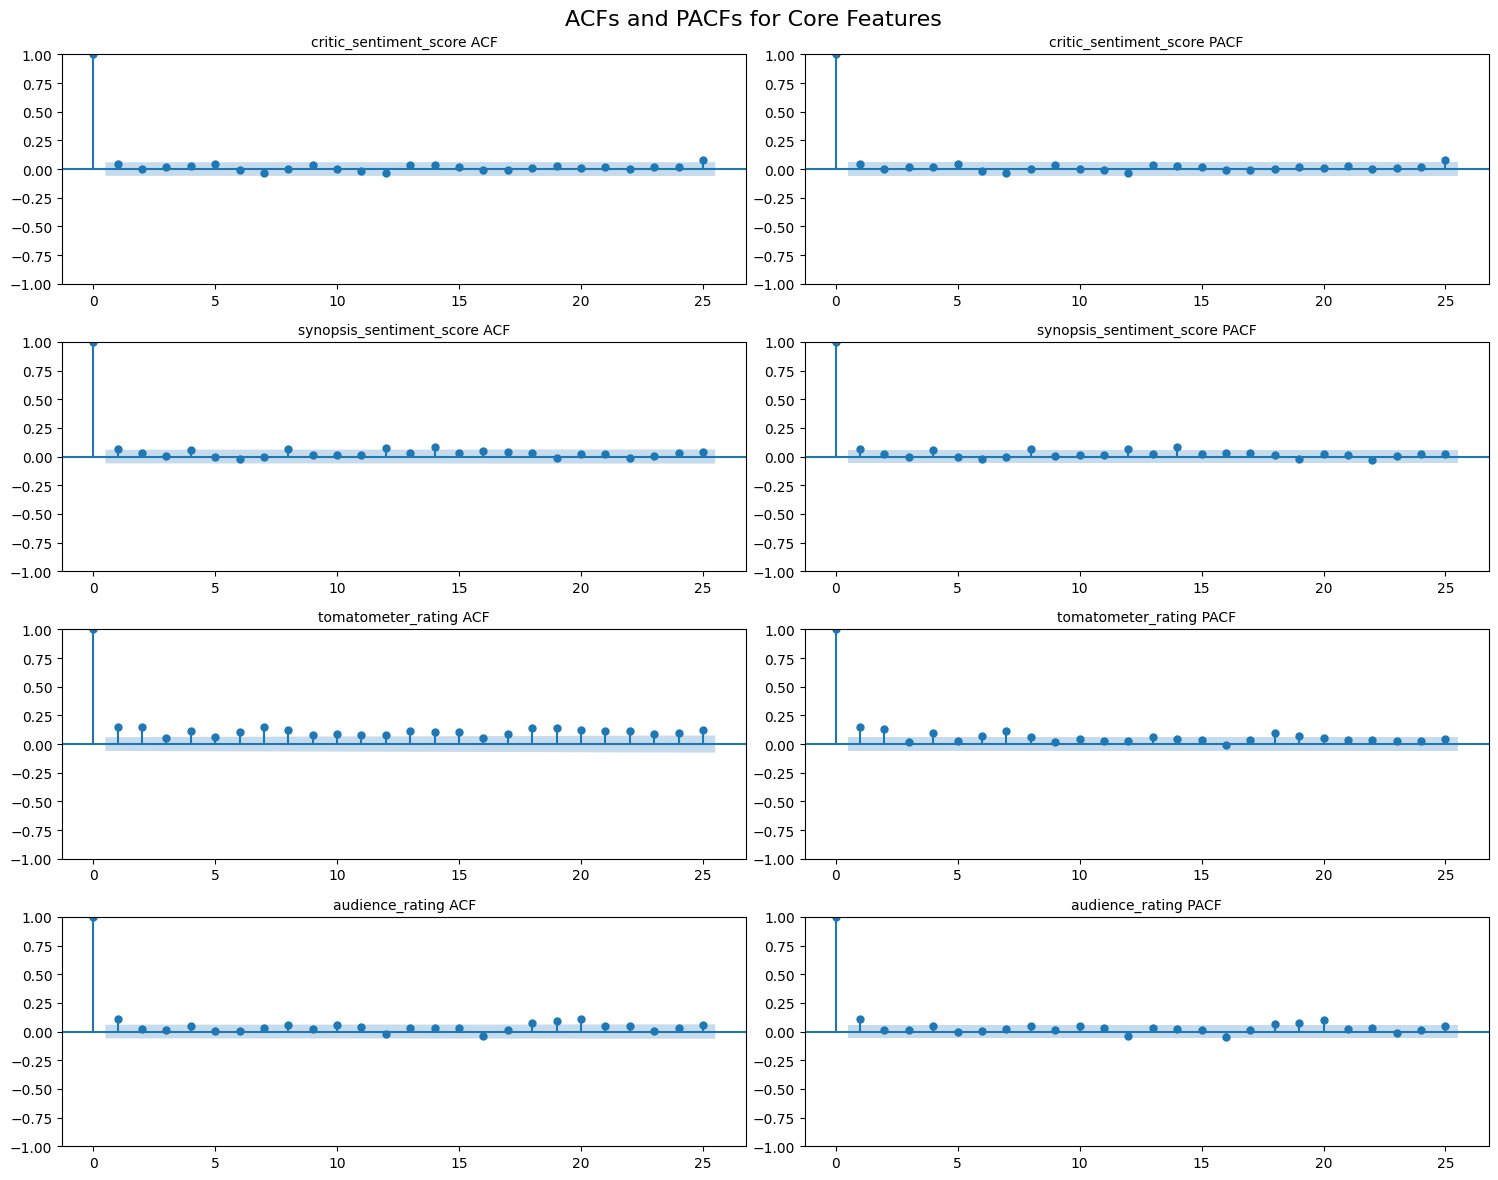

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# plot_acf(df['critic_sentiment_score'], lags=25, ax=ax[0])
# plot_pacf(df['critic_sentiment_score'], lags=25, ax=ax[1])

# plt.show()




f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
f.suptitle('ACFs and PACFs for Core Features', fontsize=16)

for i, column in enumerate(core_columns):
    plot_acf(df[column], lags=25, ax=ax[i,0])
    ax[i,0].set_title(f'{column} ACF', fontsize=10)
    plot_pacf(df[column], lags=25, ax=ax[i,1])
    ax[i,1].set_title(f'{column} PACF', fontsize=10)


plt.tight_layout()
plt.show()

## Part 5: Modeling

In [100]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['critic_sentiment_score']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

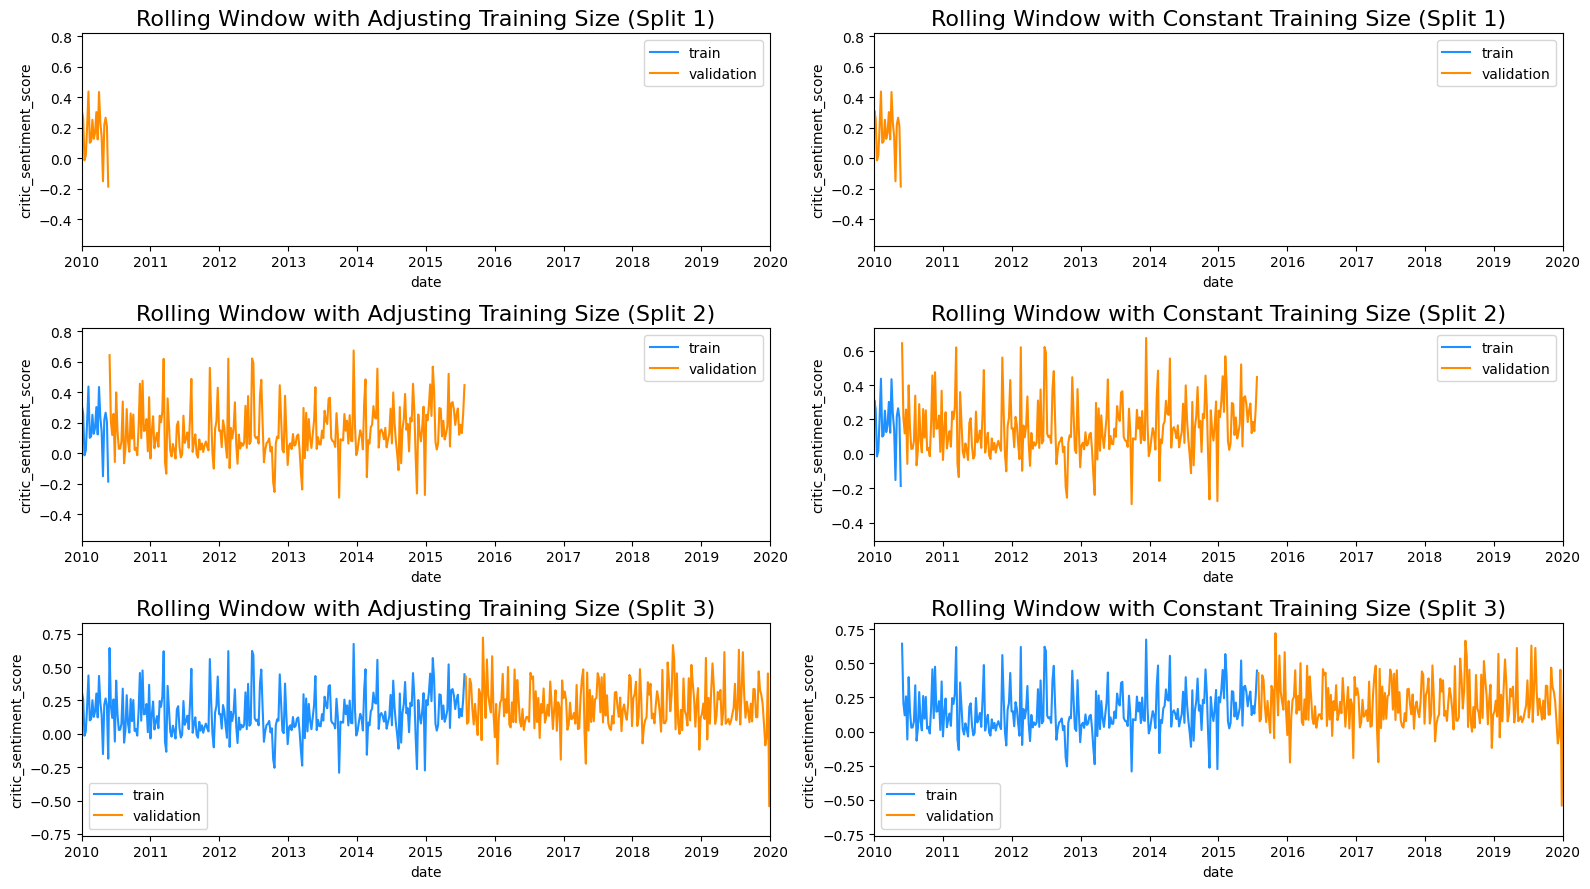

In [102]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
    ax[i, 1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test sets should we use to fit the model in each iteration.

## Part 5B: Univariate Time Series

Univariate time series: 

Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [103]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'critic_sentiment_score']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

920 163


## Prophet

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))